# Model project: The Meltzer-Richard Model

In [72]:
# Import relevant packages
import numpy as np
import pandas as pd
import re
import math
import scipy as sp
from scipy import linalg, optimize, interpolate
from scipy.stats import gamma, chi2, expon
import sympy as sm
from sympy import sympify
import matplotlib.pyplot as plt


sm.init_printing(use_unicode=True)

## Setting up the model

Consider a static economy producing a single commodity. There is a continuum of individuals, differing in one dimension only. As economic agents they  work and consume. As voters they evaluate a simple redistributive program that pays a lump sum to each individual, financed by a proportional income tax.

The **preferences** of the i'th individual are quasi-linear and given by

\\[ w_i = c_i + V(x_i), \\]

where c and x denote consumption and leisure, respectively, and V(x) is a concave utility function. **The private budget constraint** is given by

\\[ c_i \leq (1-\tau)l_i + f, \\]

where $\tau$ is the income tax rate, $l_i$ is individual labor supply and $f$ is a lump sum transfer. The real wage is normalized to 1.

We assume that individual productivity differs and that productivity, in turn, is equivalent to having more "effective time" available. For that reason, individuals are also subject to a **time constraint**: 

\\[ 1 + e_i \geq x_i + l_i, \\]

where $e_i$ captures individual productivity - more productive individuals have a larger effective time endowment, $e_i$. We further assume that $e_i$ is distributed according to a known distribution function with mean $e$ and median $e_m < e$

First, we define all symbols and equations that we are going to use:

In [73]:
# Define symbols

w = sm.symbols('w_i')
c = sm.symbols('c_i')
x = sm.symbols('x_i')
tau = sm.symbols('tau')
l = sm.symbols('l_i')
f = sm.symbols('f')
ei = sm.symbols('e_i')
e = sm.symbols('e')
V = sm.symbols('V(x_i)')

In [74]:
# Define preferences and the utility function, V(x)
V = sm.ln(x)
preferences = sm.Eq(w, c + V)
preferences

In [75]:
# We define the preferences as a sympy-function instead of an equation:
w = c + V
w

In [76]:
# Define the privat budget constraint
privat_BC = sm.Eq(c, (1-tau)*l + f)
privat_BC

In [561]:
# Define the privat time constraint
privat_timecons = sm.Eq(1 + ei, x + l)
privat_timecons

Next, we solve for leisure, $x_i$, and consumption, $c_i$, respectively, and substitute the expression into the utility function, $w_i$.

In [77]:
# Solve for x
x_from_privat_timecons = sm.solve(privat_timecons,x)

# Solve for c
c_from_privat_BC = sm.solve(privat_BC,c)

# Substitute into w
w_subs = w.subs([(x,x_from_privat_timecons[0]), (c,c_from_privat_BC[0])])
w_subs

The individual is thus facing the following maximazation problem

\\[ \max_{l_i} w_i = (1-\tau)l_i + f + V(1+e_i-l_i)\\]

By solving the maximazation problem we can find the individual labor supply, $l_i$

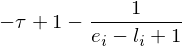

In [78]:
# Diffrentiate with respect to labor supply
FOC = sm.diff(w_subs,l)
FOC

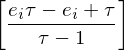

In [79]:
# Isolating labor supply
laborsupply = sm.solve(FOC,l) 
laborsupply

Which can also be stated as

\\[ l_i = 1 + e_i - \frac{1}{1-\tau}\\]

This expression shows that labor supply is decreasing in $\tau$. In other words, a higher tax rate distorts the labor-leisure choice and induces the consumer to work less.

We also introduce the average labor supply, which is given by

\\[ L(\tau) = 1 + e - \frac{1}{1-\tau}\\]

This means that we can state individual labor supply as

\\[ l_i = L(\tau) + (e_i - e)\\]

Lastly, we state the government's budget constrain which is given by 

\\[ f \leq \tau L(\tau)\\]


We re-write the labor supply and government's budget as a sympy-function

In [80]:
# Reformulating labor supply
L = sm.Function('L')(tau)
laborsupply = L + (ei-e)
laborsupply

In [81]:
# Defining the government's budget constraint
government_BC = tau*L
government_BC

We now substitute all of this back into $w_i$ to obtain the indirect utility function which is then a function of redistributive policy $\tau$ :

In [82]:
# Substituting laborsupply and the government's budget constraint into w
indirect_utility = w_subs.subs([(l,laborsupply), (f,government_BC)])
indirect_utility = sm.simplify(indirect_utility)
indirect_utility

This expression describes individual utility *given* the tax rate. However, as individuals differ they all prefer a different tax rate. By maximazing the indirect utility function with respect to $\tau$, and afterwards isolating $\tau$ we can obtain the preferred tax rate for individual $i$:

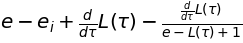

In [568]:
# Diffrentiate with respect to labor supply
pref_tax = sm.diff(indirect_utility, tau)
pref_tax

Next, we want to insert the expression for the average labor supple, $L(\tau)$, while keeping the diffrentiated average labor as it is. However, we have struggled to do a "proper" substitution and for that reason we have chosen a qiute manual approach.

In [83]:
# Define diffrentiated average labor supply, explicitly
L_diff = sm.diff(L,tau)

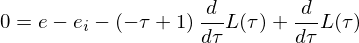

In [84]:
# Substitute this into the diffrentiated indirect utility function, pref_tax, by defining the equation once again 
pref_tax = sm.Eq(0,e-ei+L_diff-L_diff/(e-(1+e-(1/(1-tau)))+1))
pref_tax

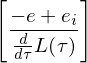

In [85]:
# Solve for the preferred tax rate for individual i
pref_tax_solve = sm.solve(pref_tax,tau)
pref_tax_solve

This shows that our closed form solution can be written as

\\[ \tau_i = \frac{e-e_i}{-\frac{d}{d\tau}L(\tau)} \\]

Recall that $\frac{d}{d\tau}L(\tau) < 0$. This means that an individual with productivity, and hence income, *below* average will prefer a positive tax rate that is larger the poorer that individual is (the larger is $(e-e_i)$. On the other hand, an individual with productivity *above* average will prefer a negative tax rate (income subsidy, $\tau<0$),  financed by a lump sum tax. 

To illustrate this relationship we plot the preferred tax rate as a function of individual productivity, $e_i$

In [86]:
# Define the function L
L = (1+e-1/(1-tau))

# Differentiate L and define the closed form solution, pref_tax, as a function
L_diff = sm.diff(L, tau)
pref_tax = (-e+ei)/(L_diff)
pref_tax

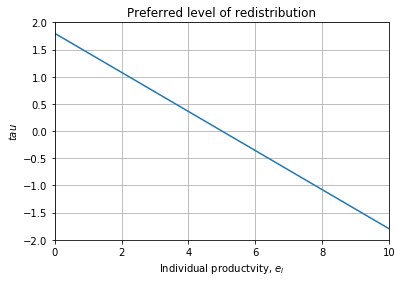

In [87]:
# Turn the function into a python function
pref_tax_func = sm.lambdify((e,ei,tau), pref_tax)

# create input-value
e = 5
tau = 0.4
ei_list = [0,1,2,3,4,5,6,7,8,9,10]
pref_tax_list = [] # empty list
for x in ei_list:
    pref_tax_list.append(pref_tax_func(e,x,tau))
    
# plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ei_list,pref_tax_list)
ax.grid()
ax.set_xlabel('Individual productvity, $e_i$')
ax.set_ylabel('$tau$')
ax.set_title('Preferred level of redistribution')
ax.set_xlim([0,10])
ax.set_ylim([-2,2]);

This figure clearly illustrates that the preferred tax rate is a negative function of individual productivity and hence income.

As all individuals in this model differs and thus prefers a different tax rate the interesting question is what tax rate will be chosen? To answer this question we assume that two political candidates (who only care about winning the election) are running for office and committing themselves to electoral platforms formulated over the tax rate. Whoever wins the election eneacts the preannounced policy.

Next, we introduce and apply the *median voter theorem*, which in short (and imprecise) terms says that the only relevant person in the electorate is the median voter. The median voter is decisive because (under the assmuption that preferences are monotonic in $e_i$) if that person agrees to a policy then at least half of the electorate will also prefer that policy over an alternative policy which is further away from the median. Hence, if either of the candidates were to announce a policy $\tau'$ that was different from $\tau^m$ (the policy preferred by the median voter) the other candidate could ensure victory by announcing a policy in the interval $(\tau',\tau^m$). Thus, the equilibrium tax rate must coincide with the policy preferred by the median voter:

\\[ \tau_m = \frac{e-e_m}{-\frac{d}{d\tau}L(\tau)} \\]

This result implies that the skewness of the income distribution influences the degree of redistribution in the society. 

## Model output

The Meltzer-Richard Model as presented in 1.1 illustrates that the preferred degree of redistribution depends on the income distribution in the society. In specific, the model specifies that the relation between the mean income and the median income defines the preferred degree of redistribution. In the following we will apply the model in a simulation based on the income distribution distributed according to a gamma distribution, a chi2 distribution and an exponential distribution, respectively.

At first, we will illustrate it by dragging a mean and median from a gamma distribution and calculate the preferred redistribution. In the following section we will extend with the chi2 distribution and the exponential distribution.

In [88]:
# Dataframe for draws from distribution
df = pd.DataFrame()

# draws from gamma distribution
size = 200000
df['gamma'] = gamma.rvs(5, size=size)

# print median and mean
tau_ = 0.4
print(' Mean: \n',round(df['gamma'].mean(),3))
print('\n Median: \n',round(df['gamma'].median(),3))

# print results
print('\n \u03C4: \n', round(pref_tax_func(df['gamma'].mean(),df['gamma'].median(),tau_),4))

 Mean: 
 5.002

 Median: 
 4.671

 τ: 
 0.1194


Thus, in a simple stylized model society where the mean income is 5 and the median income is 4.67, the preferred tax rate is 0,12. 

We will now drag mean and median from the other distributions as well, whereby we can show that the relation between the mean and the median (i.e. the skewness of the income distribution) defines the preferred tax rate according to this model and the median voter theorem.

In [89]:
# draws from chi2 and exponential distribution
df['chi2'] = chi2.rvs(5, size=size)
df['expon'] = expon.rvs(5, size=size)

# print mean and median
print(' Mean: \n Gamma:',round(df['gamma'].mean(),3),
      '\n Chi2:', round(df['chi2'].mean(),3),
      '\n Exponential:', round(df['expon'].mean(),3))

print('\n Median: \n Gamma:',round(df['gamma'].median(),3),
      '\n Chi2:', round(df['chi2'].median(),3),
      '\n Exponential:', round(df['expon'].median(),3))

 Mean: 
 Gamma: 5.002 
 Chi2: 4.998 
 Exponential: 5.999

 Median: 
 Gamma: 4.671 
 Chi2: 4.347 
 Exponential: 5.69



The relation between the mean the median differs between the three distributions which we will illustrate in a figure below.

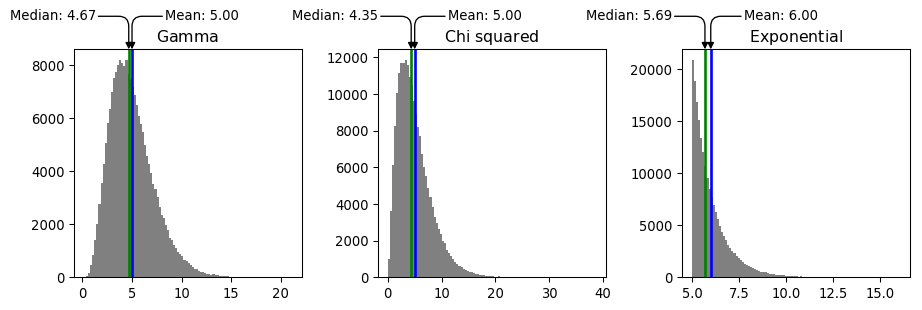

In [90]:
# Add figure
fig = plt.figure(figsize=(8, 6), dpi=95, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.1, 0.04, 0.3, 0.4])
ax2 = fig.add_axes([0.5, 0.04, 0.3, 0.4])
ax3 = fig.add_axes([0.9, 0.04, 0.3, 0.4])


# subplot titles
ax1.title.set_text('$\mathrm{Gamma}$')
ax2.title.set_text('$\mathrm{Chi}$' +' '+'$\mathrm{squared}$')
ax3.title.set_text('$\mathrm{Exponential}$')

# plot distriutions
ax1.hist(df['gamma'], color = 'grey', bins = 100)
ax2.hist(df['chi2'], color = 'grey', bins = 100)
ax3.hist(df['expon'], color = 'grey', bins = 100)

# add median and mean lines 
ax1.axvline(df['gamma'].mean(), color='blue', linewidth=2)
ax1.axvline(df['gamma'].median(), color='green', linewidth=2)

# Add arrows annotating the means: 
x0 = df['gamma'].mean()
ax1.annotate('Mean: {:0.2f}'.format(x0), xy=(x0, 1), xytext=(25, 25),
            xycoords=('data', 'axes fraction'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )

x0 = df['gamma'].median()
ax1.annotate('Median: {:0.2f}'.format(x0), xy=(x0, 1), xytext=(-25, 25),
            xycoords=('data', 'axes fraction'), textcoords='offset points',
            horizontalalignment='right', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )

# add median and mean lines 
ax2.axvline(df['chi2'].mean(), color='blue', linewidth=2)
ax2.axvline(df['chi2'].median(), color='green', linewidth=2)

x0 = df['chi2'].mean()
ax2.annotate('Mean: {:0.2f}'.format(x0), xy=(x0, 1), xytext=(25, 25),
            xycoords=('data', 'axes fraction'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )

x0 = df['chi2'].median()
ax2.annotate('Median: {:0.2f}'.format(x0), xy=(x0, 1), xytext=(-25, 25),
            xycoords=('data', 'axes fraction'), textcoords='offset points',
            horizontalalignment='right', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )

# add median and mean lines 
ax3.axvline(df['expon'].mean(), color='blue', linewidth=2)
ax3.axvline(df['expon'].median(), color='green', linewidth=2)

x0 = df['expon'].mean()
ax3.annotate('Mean: {:0.2f}'.format(x0), xy=(x0, 1), xytext=(25, 25),
            xycoords=('data', 'axes fraction'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )

x0 = df['expon'].median()
ax3.annotate('Median: {:0.2f}'.format(x0), xy=(x0, 1), xytext=(-25, 25),
            xycoords=('data', 'axes fraction'), textcoords='offset points',
            horizontalalignment='right', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )

plt.show()

From the figure, we notes that the chi2 distribution implies the biggest difference between the mean income and the median income, whereas the exponential distribution implies the smallest difference. As presented in 1.1, we will expect the preferred level of redistribution to be greater in the society illustrated by the chi2 distribution. This we will now test by calculating the preferred tax level for the three distributions.

In [91]:
# calculating results
gamma = pref_tax_func(df['gamma'].mean(),df['gamma'].median(),tau_)
chi2 = pref_tax_func(df['chi2'].mean(),df['chi2'].median(),tau_)
expon = pref_tax_func(df['expon'].mean(),df['expon'].median(),tau_)

#printing results
print('\u03C4 \n:'
      'gamma:', round(gamma,3), '\n'
     'chi2:', round(chi2,3), '\n'
     'expon:', round(expon,3))

τ 
:gamma: 0.119 
chi2: 0.234 
expon: 0.111


Thus, we can see that the preferred level of redistribution is greater in the model, where the difference between the mean and the median is bigger.